This notebook applies posterior sampling on the $\varphi^4$ model. Only the case where the hamiltonian is linearly shifted by a magnetic field $h$ is treated. Neural networks weight are **not** provided.

### Software pre-requisites

In [1]:
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import torch  # 2.0 or greater
    from torch.func import vmap
    from torch import nn
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import torch.nn.functional as F
    from torch.nn import MSELoss
    from torch.cuda import amp
    
    print("All packages are installed!")
except ImportError as e:
    print(f"An error occurred: {e}. Please make sure all required packages are installed.")

from typing import Callable
import math

batch_size = 70
criterion = MSELoss()
dim_phi = 32

All packages are installed!


In [2]:
phi_32 = torch.tensor(np.load("/mnt/live/user/fcoeurdou/dataset/phi4_L32_m2-4.0_lam4.572.npy"))[:70000]

In [3]:
phi_loader = DataLoader(dataset=phi_32, batch_size=batch_size, shuffle=True)

In [4]:
img = next(iter(phi_loader))

In [5]:
img = phi_32[0].unsqueeze(0)

In [6]:
mag_true = (torch.mean(phi_32, dim=(1,2)))

Text(0.5, 1.0, 'Distribution of $M[\\phi(x)] = \\sum_x \\phi(x)$')

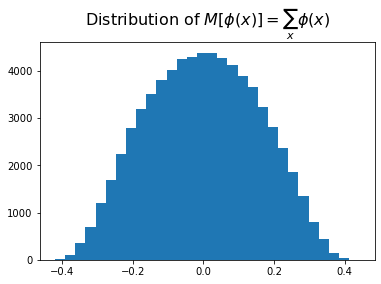

In [7]:
plt.hist(mag_true.detach().cpu().numpy(), bins = 30)
plt.title(r"Distribution of $M[\phi(x)] = \sum_x \phi(x)$", fontsize = 16)

In [8]:
def grab(var):
    return var.detach().cpu().numpy()

In [9]:
device = 'cpu'

In [10]:
from torch.distributions import MultivariateNormal

class BaseDistribution:
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor, device=device): 
        self.mean = mean
        self.covariance = cov
        self.distribution = MultivariateNormal(mean.to(device), cov.to(device))
    
    def sample(self, n: int=1):
        """
        Draws $n$ samples from the Gaussian distribution.
        """
        return self.distribution.sample((n,)).reshape(n, 1, dim_phi, dim_phi)
    
    def log_prob(self, x: torch.Tensor):
        """
        Evaluates the log probability of given samples $x$ under the distribution. 
        """
        return self.distribution.log_prob(x)

dim = img.reshape(-1).shape[0]
mean = torch.zeros(dim)  # \mu \in R^2
cov = torch.eye(dim)  # \Sigma \in R^{2x2}

base = BaseDistribution(mean, cov)

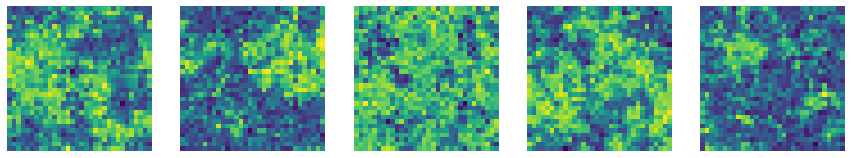

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Get the ith image and reshape it to 28x28
    img = phi_32[i].reshape(dim_phi, dim_phi)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
plt.show()

In [12]:
import random

def target(n, dataset=phi_32, device=device):
    # Randomly sample n indices from the dataset
    indices = random.sample(range(len(dataset)), n)
    # Use list comprehension to gather images and labels for these indices
    images = torch.stack([phi_32[i].unsqueeze(0) for i in indices])    
    return images.to(device)

In [13]:
target(2).shape

torch.Size([2, 1, 32, 32])

When one abstracts away the time $t$, and consider the interpolant parameterized with $\alpha$: 
$$
I_\alpha = \alpha \odot x_0 + (1 - \alpha)\odot x_1, \qquad x_0 \sim \rho_0, \, x_1 \sim \rho_1
$$

Since $b(x, \alpha) = \mathbb{E}[\partial_\alpha I_\alpha | I_\alpha = x] = \mathbb{E}[x_0 - x_1 | I_\alpha = x] = \eta_0(x, \alpha) - \eta_1(x, \alpha)$.

In [14]:
class Interpolant:
    """
    Interpolant class parameterized with alpha.
    """
    def _single_xt(self, x0, x1, alpha):
        if len(alpha.shape) != len(x0.shape):
            alpha = alpha.reshape(*x0.shape)
        return alpha*x0 + (1 - alpha)*x1
    
    def _single_dtxt(self, x0, x1):
        return x0 - x1
    
    def xt(self, x0, x1, alpha):
        if len(alpha.shape) != len(x0.shape):
            alpha = alpha.reshape(*x0.shape)
        return vmap(self._single_xt, in_dims=(0, 0, 0))(x0,x1,alpha)
    
    def dtxt(self, x0, x1):
        return vmap(self._single_dtxt, in_dims=(0, 0))(x0,x1)
    
interpolant = Interpolant()

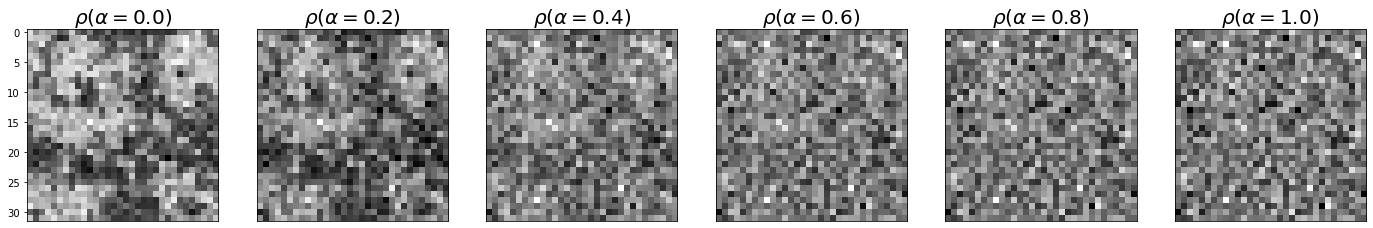

In [15]:
bs = 1
ncol = 6
ts   = torch.linspace(0, 1, ncol)
x0s = base.sample(bs)
x1s = target(bs)
fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,4))
Alpha = torch.cat((ts[:,None],)*dim, axis = 1)

for i, alpha in enumerate(Alpha):
    
    alpha  = alpha.repeat(bs, 1).to(device).reshape(*x1s[0].shape)
    xts = interpolant.xt(x0s, x1s, alpha)
    
    axes[i].imshow(xts.reshape(dim_phi, dim_phi).to("cpu"), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_title(r'$\rho(\alpha = %.1f)$' % alpha[0, 0, 0].item(), fontsize = 20, weight='bold')
    
    if i !=0:
        axes[i].set_yticks([])

del x0s; del x1s; del Alpha

### Neural Network $\hat b_t(x)$ to model $b_t(x)$

Now we need to define a neural network which has learnable parameters to model $b_t(x)$. Recall that the velocity field takes in a time coordinate and a spatial sample which is $\mathbb R^2$. This means that our neural network approximation $\hat b_t(x)$ should be a function that has an input size of $1 + \text{space dim} = 3$ and should have an output dimension of $\text{space dim} = 2$. 

To define a neural network, we'll use PyTorch's `torch.nn.Module` library which allows us to compose parts of the neural network in a way that allows us to take derivatives with respect to the networks weights:

In [16]:
# This is the utils file
def zero_out(layer):
    for p in layer.parameters():
        p.detach().zero_()
    return layer

# AdaGN according to paper "Diffusion Models Beat GANs on Image Synthesis"
class AdaNorm(nn.Module):
    def __init__(self, num_channel: int):
        super().__init__()
        num_group = int(num_channel/16) # According to group norm paper, 16 channels per group produces the best result
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor, emb: torch.Tensor):
        scale, shift = torch.chunk(emb, 2, dim=1)
        tensor = self.gnorm(tensor)
        tensor = tensor * (1 + scale) + shift
        return tensor


class MyGroupNorm(nn.Module):
    def __init__(self, num_channel: int):
        super().__init__()
        num_group = int(num_channel/16) # According to group norm paper, 16 channels per group produces the best result
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor):
        return self.gnorm(tensor)

        
class ResBlock(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, emb_dim: int = 1024, up: bool = False, down: bool = False):
        super().__init__()
        self.emb = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, 2*out_channel))
        if up:
            self.change_size = nn.Upsample(scale_factor=2, mode='nearest')
        elif down:
            self.change_size = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.change_size = nn.Identity()

        # Normalization
        self.gnorm1 = MyGroupNorm(in_channel)
        self.gnorm2 = AdaNorm(out_channel)

        # Convolution
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1)
        if in_channel != out_channel:
            self.conv3 = nn.Conv2d(in_channel, out_channel, kernel_size = 1)
        else:
            self.conv3 = nn.Identity()

        # Combine input stage
        self.input = nn.Sequential(
            self.gnorm1,
            nn.SiLU(),
            self.change_size,
            self.conv1
        )

        # Combine output stage
        self.output = nn.Sequential(
            nn.SiLU(),
            zero_out(self.conv2)
        )

        # Skip connection
        self.skip_connection = nn.Sequential(
            self.change_size,
            self.conv3
        )

        # Embedding
        self.embed = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, 2 * out_channel)
        )

    def forward(self, tensor: torch.Tensor, emb: torch.Tensor):
        emb = self.embed(emb).view(tensor.shape[0], -1, 1, 1)

        h = self.input(tensor)
        h = self.gnorm2(h, emb)
        h = self.output(h)
        x = self.skip_connection(tensor)

        return x + h

class SelfAttention(nn.Module):
    def __init__(self, channel: int):
        super().__init__()
        self.num_head = int(channel/32)

    def forward(self, tensor: torch.Tensor):
        batch, channel, length = tensor.shape
        ch = channel // 3 // self.num_head
        q, k, v = tensor.chunk(3, dim = 1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        # The code below is from Diffusion Model Beat GANs on Image Synthesis paper code
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(batch * self.num_head, ch, length),
            (k * scale).view(batch * self.num_head, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(batch * self.num_head, ch, length))
        return a.reshape(batch, -1, length)


class Attention(nn.Module):
    def __init__(self, channel: int):
        super().__init__()
        self.gnorm = MyGroupNorm(channel)
        self.qkv = nn.Conv1d(channel, channel * 3, 1)
        self.attention = SelfAttention(channel)
        self.output = zero_out(nn.Conv1d(channel, channel, 1))

    def forward(self, tensor: torch.Tensor):
        # Perform self attention
        batch, channel, width, height = tensor.shape
        tensor = tensor.reshape(batch, channel, -1)
        # Skip connection
        tensor_skip = tensor
        tensor = self.gnorm(tensor)
        tensor = self.qkv(tensor)
        tensor = self.attention(tensor)
        tensor = self.output(tensor)

        # Adding the skip connection tensor back to the current tensor
        tensor = tensor + tensor_skip

        tensor = tensor.reshape(batch, channel, width, height)
        return tensor


class UNet(nn.Module):
    def __init__(self, image_channel: int = 1, depth: int = 2, emb_dim: int = 1024):
        super().__init__()

        # Create model architecture
        channels = [160, 320, 544, 608]
        attention_channel = [544, 608]
        self.encoder = nn.ModuleList([nn.ModuleList([nn.Conv2d(image_channel, channels[0], 3, padding=1)])])
        self.decoder = nn.ModuleList()

        skip_channel = [channels[0]]

        # Encoder
        for i in range(len(channels)):
            for _ in range(depth):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channel:
                    layer.append(Attention(channels[i]))
                self.encoder.append(layer)
                skip_channel.append(channels[i])

            if i != len(channels)-1:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i + 1], down=True, emb_dim = emb_dim))
                self.encoder.append(layer)
                skip_channel.append(channels[i+1])

        # Bottleneck
        self.bottle_neck = nn.ModuleList([
            ResBlock(channels[-1], channels[-1], emb_dim = emb_dim),
            Attention(channels[-1]),
            ResBlock(channels[-1], channels[-1], emb_dim = emb_dim),
        ])

        # Decoder
        for i in range(len(channels)-1, -1, -1):
            for block in range(depth+1):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channel:
                    layer.append(Attention(channels[i]))

                if i != 0 and block == depth:
                    layer.append(ResBlock(channels[i], channels[i - 1], up=True, emb_dim = emb_dim))

                self.decoder.append(layer)

        # Create time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        # Output kernels to change back to image channel
        self.out = nn.Sequential(
            MyGroupNorm(channels[0]),
            nn.SiLU(),
            zero_out(nn.Conv2d(channels[0], image_channel, 3, padding=1)),
        )

    def forward(self, tensor: torch.Tensor, time_embedding: torch.Tensor):
        # Creating embedding
        embedding = self.time_embedding(time_embedding)
        
        skip_connection = []

        # Encoder
        for layer in self.encoder:
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

            skip_connection.append(tensor)

        # Bottleneck
        for module in self.bottle_neck:
            if(isinstance(module, ResBlock)):
                tensor = module(tensor, embedding)
            else:
                tensor = module(tensor)

        # Decoder
        for layer in self.decoder:
            P = skip_connection.pop()
            if P.shape[-1] == tensor.shape[-1] + 1:
                tensor= F.pad(tensor, (1, 0, 1, 0), "constant", 0) 

            tensor = torch.concatenate((tensor, P), dim = 1)
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

        tensor = self.out(tensor)

        return tensor


class VelocityFieldImage(nn.Module):
    def __init__(self, init_features=28, device='cpu'):
        super(VelocityFieldImage, self).__init__()
        # Increment the input channels by 1 to accommodate the alpha dimension
        self.unet = UNet(image_channel = 1, depth = 2, emb_dim = init_features**2).to(device)

    def forward(self, x, alpha):
        """
        Important Note: alpha should be a linear vector, and not a matrix.
        """
        return self.unet(x, alpha)

class ODE:
    def __init__(self, b: VelocityFieldImage, interpolant: Interpolant, n_step: int, Alpha: torch.Tensor = None, mask: torch.Tensor = None, device: str = device):
        """
        Attributes:
            b: VectorField. Generator of the flow.
            interpolant: Interpolant. This is the interpolant between source and target distribution.
            n_step: int. Step size for the resolution of the ODE.
            Alpha : Tensor. It is the trajectory in the alpha-space of the stochastic interpolant.
            mask: Tensor. Mask the generator for the non-corrupted entries.
        """
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        self.device = device
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*dim, axis = 1)
        else:
            self.alpha = Alpha
        self.dt          = 1/n_step
        if mask is None:
            self.mask = torch.ones(self.alpha.shape[-1], device = device)
        else:
            assert len(mask) == self.alpha.shape[-1], "The mask should have the shape of the data space"
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

    def step(self, x: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
        mask = self.mask.reshape(*x.shape[1:])
        gen = self.b(x, alpha)
        return x - 1*mask*gen*self.dt
    
    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1) #Repeat for each batch size
            x = self.step(x, alpha)
            xs[i] = x
        return xs

In [17]:
b = VelocityFieldImage(init_features=dim_phi, device=device)

N = 8
x = target(N)

alpha = torch.rand(N, *x[0].shape).to(device).reshape(N, -1)

# print(x.shape)
# print(alpha.shape)

output = b(x, alpha)
print(torch.linalg.norm(output).item())

alpha = alpha.requires_grad_(True)
print(alpha.requires_grad)
del output; del alpha; del x

0.0
True


In [18]:
def loss_fn(b, interpolant, x0, x1, alpha):
    """
    Interpolant loss function for a single datapoint of (x0, x1, t).
    """
    It   = interpolant.xt(x0, x1, alpha)
    dtIt = interpolant.dtxt(x0, x1)
    bt          = b.forward(It, alpha)
    loss        = criterion(bt, dtIt)
    return loss


N = 10
x0s = base.sample(N)
x1s = target(N)
alpha = torch.rand(N, *x1s[0].shape).to(device).reshape(N, -1)
l = loss_fn(b, interpolant, x0s, x1s, alpha)
print(l.mean().item())
del alpha; del x1s; del x0s

1.276709794998169


#### Training step

Now that we have constructed our loss, let's put it in a loop to interatively update the parameters of $\hat b$ and $\hat \eta_t(x)$ as we move toward the minimizer of $\mathcal L_b[\hat b]$ and $\mathcal L_\eta[\hat \eta]$. 

To perform this parameter update, we need to introduce a pytorch `optimizer` that performs the gradient update for us. We do that via the following, specifying a learning rate `lr`. We use the `Adam` optimizer, which is a fancier version of SGD.

Now lets use it in a function called `train_step` which will perform our iteration:

In [19]:
def train_step(b, interpolant, opt, sched, scaler):
    ## Training

    #Set the neural network to training mode
    b.train()
    # evaluate train loss
    for x1s in phi_loader:
        opt.zero_grad()
        x1s = x1s.unsqueeze(1).to(device)
        x0s = base.sample(batch_size)
        alpha = torch.rand(batch_size, 1).to(device).repeat(1, 32*32)

        with amp.autocast():
            loss_train = loss_fn(b, interpolant, x0s, x1s, alpha)/batch_size
        # perform backprop
        scaler.scale(loss_train).backward() #Scale the loss
        torch.nn.utils.clip_grad_norm_(b.parameters(), max_norm = 1.0) #Clip the norm of the gradients
        scaler.step(opt) #Update the parameters' gradient
        scaler.update()
    sched.step()

    ##Validation

    #Set the neural network to evaluation mode
    b.eval()

    x0s_eval = base.sample(batch_size)
    x1s_eval = target(batch_size)
    # alpha_eval = torch.rand(batch_size, 1).to(device).repeat(1, 28*28)
    alpha_eval = torch.rand(batch_size, 32*32, device = device)
    with amp.autocast():
        #Evaluate loss on validation dataset
        loss_eval = loss_fn(b, interpolant, x0s_eval, x1s_eval, alpha_eval)/batch_size

    res = {
            'loss': loss_train.detach(),
            'loss_eval': loss_eval.detach()
        }
    return res

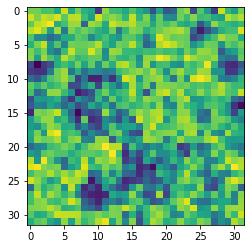

In [20]:
x1s = target(N)
plt.imshow(x1s[0].reshape(dim_phi,dim_phi).cpu())
del x1s

#### Running the Training

We are now ready to train our model. Let's build a loop that runs for `n_opt` stepsand store the loss over time.

In [21]:
%%time
Load = True
warm_up = True
if not Load:
    b = VelocityFieldImage(init_features=dim_phi, device=device)
    if warm_up:
        b.load_state_dict(torch.load("/mnt/live/user/fcoeurdou/weight_UNET_PHI.pth"))
    print("This model has", sum(p.numel() for p in b.parameters()), "parameters.")
    lr = 3e-4
    weight_decay = 0.1
    n_opt = 100
    scaler = amp.GradScaler()
    opt = torch.optim.AdamW(b.parameters(), lr = lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.991)

    losses = []
    losses_eval = []
    from tqdm import tqdm
    pbar = tqdm(range(n_opt))
    for i in pbar:
        
        res = train_step(b, interpolant, opt, sched, scaler)
        
        loss = res['loss'].to('cpu').detach().numpy().mean()
        loss_v = res['loss_eval'].to('cpu').detach().numpy().mean()
        
        losses.append(loss)
        losses_eval.append(loss_v)
        pbar.set_description(f'Loss: {loss:.4f}, Loss eval: {loss_v: .4f}')

        if i%50 == 0:
            print(f"### Epoch {i+1}")
            print(f"The learning rate is {opt.param_groups[0]['lr']}")
            print(f"Cumulated mean train loss is {sum(losses)/len(losses)}")
    
    torch.save(b.state_dict(), "/mnt/live/user/fcoeurdou/weight_UNET_PHI.pth")
    plt.plot(losses)
    plt.plot(losses_eval)
    
if Load:
    b = VelocityFieldImage(init_features=dim_phi, device=device)
    b.load_state_dict(torch.load("/mnt/live/user/fcoeurdou/weight_UNET_PHI.pth"))
    b.eval()

CPU times: user 3.11 s, sys: 1.53 s, total: 4.63 s
Wall time: 4.62 s


In [72]:
class ODE:
    def __init__(self, b: VelocityFieldImage, interpolant: Interpolant, n_step: int, Alpha: torch.Tensor = None, mask: torch.Tensor = None, device: str = device):
        """
        Attributes:
            b: VectorField. Generator of the flow.
            interpolant: Interpolant. This is the interpolant between source and target distribution.
            n_step: int. Step size for the resolution of the ODE.
            Alpha : Tensor. It is the trajectory in the alpha-space of the stochastic interpolant.
            mask: Tensor. Mask the generator for the non-corrupted entries.
        """
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        self.device = device
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*dim, axis = 1)
        else:
            self.alpha = Alpha
        self.dt          = 1/n_step
        if mask is None:
            self.mask = torch.ones(self.alpha.shape[-1], device = device)
        else:
            assert len(mask) == self.alpha.shape[-1], "The mask should have the shape of the data space"
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

    def step(self, x: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
        mask = self.mask.reshape(*x.shape[1:])
        if alpha[0, 0] < 0.999:
            alpha_r = alpha.reshape(x.shape[0], 1, 32, 32)
            x_r = x + ((alpha_r**2) / (1-alpha_r))*0.02
            gen = self.b(x_r, alpha) - ((alpha_r) / (1-alpha_r))*0.02
        else:
            gen = self.b(x, alpha) 
        return x - 1*mask*gen*self.dt
    
    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1) #Repeat for each batch size
            x = self.step(x, alpha)
            xs[i] = x
        return xs

## Full Generation

In [75]:
x_init = base.sample(3).to(device)

ode  = ODE(b, interpolant, n_step = 50, Alpha = None, device = device)
xfs = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2
del xfs; del x_init;

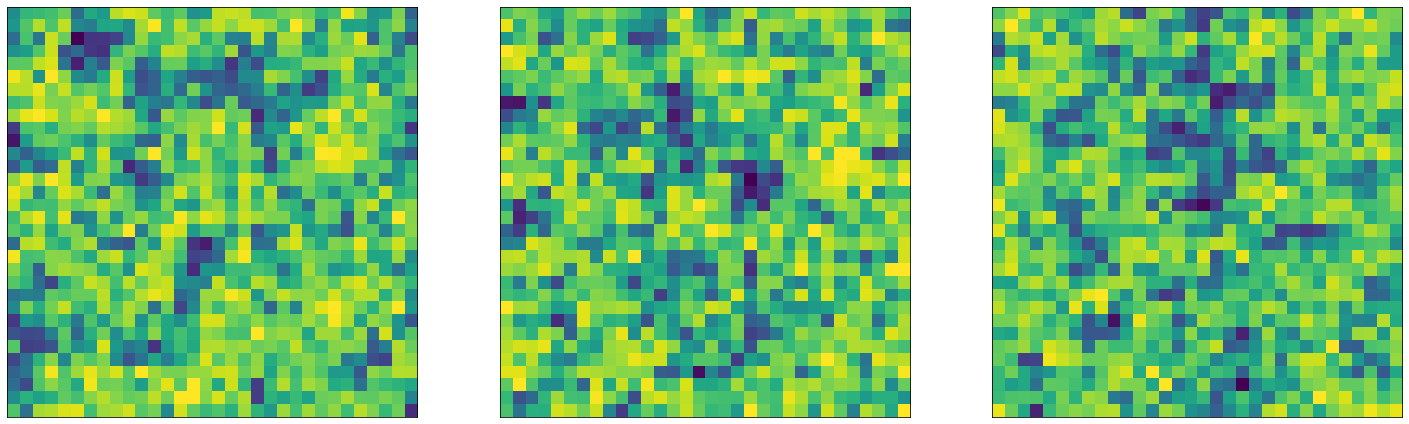

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(25,10))

for i in range(3):
    axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [ ]:
for i in range(3):
    axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [60]:
x_init = base.sample(2).to(device)
xfs = ode.solve(x_init)
mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2)))

In [61]:
mag = mag_s

In [62]:
from tqdm import tqdm

In [63]:
for _ in tqdm(range(100)):
    x_init = base.sample(2).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2)))
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s])

 85%|███████████████████████████████████████████████████████▎         | 85/100 [13:37<02:24,  9.61s/it]


KeyboardInterrupt: 

In [64]:
len(mag)

172

Text(0.5, 1.0, 'Distribution of $M[\\phi(x)] = \\sum_x \\phi(x)$')

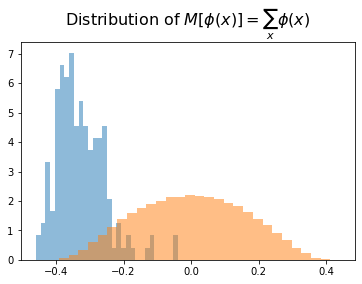

In [65]:
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True)
plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True)
plt.title(r"Distribution of $M[\phi(x)] = \sum_x \phi(x)$", fontsize = 16)